In [13]:
#Analise de dataset gerado no google colab. 
#Objetivo é explorar os conhecimento com os dados, gerando vizualização e insights. 
# Igor Tarciano Gomes da Silva
# Data de Inicio: 29/05/2025; 
# linguagem: Python
# Bibliotecas: 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats

In [24]:
# principais informações descritivas;
import pandas as pd 
Data_set = pd.read_csv('dados_produtos_vendas.csv')

# Ordem dos produtos com maior qnt de vendas
Ord_sales_product_Data_set = Data_set.groupby(['ID_produto','descricao'])[['quantidade em estoque','quantidade vendida']].sum().sort_values(by='quantidade vendida',ascending=False)

# Ordem dos itens com maiores faturamentos
Data_set['Value_Total_sales_Data_set'] = Data_set['quantidade vendida']*Data_set['valor unitario']
Invoicing_total_sales = Data_set.groupby(['ID_produto','descricao'])['Value_Total_sales_Data_set'].sum().sort_values(ascending=False).head(150)

# Criar os index: dos anos/meses/dias e dias por semanas, das vendas. 
Data_set['data de venda'] = pd.to_datetime(Data_set['data de venda'])
Data_set['Anos vendas'] = Data_set['data de venda'].dt.year
Data_set['Meses vendas'] = Data_set['data de venda'].dt.month
Data_set['Dias vendas'] = Data_set['data de venda'].dt.day
Data_set['Dias da semana vendas'] = Data_set['data de venda'].dt.dayofweek

# Criar os index: dos anos/meses/dias e dias por semanas, das entradas n132o estoque. 
Data_set['data da entrada em estoque'] = pd.to_datetime(Data_set['data da entrada em estoque'])
Data_set['Anos'] = Data_set['data da entrada em estoque'].dt.year
Data_set['Meses'] = Data_set['data da entrada em estoque'].dt.month
Data_set['Dias'] = Data_set['data da entrada em estoque'].dt.day
Data_set['Dias da semana'] = Data_set['data da entrada em estoque'].dt.dayofweek

In [25]:
# Medidas descritivas
import pandas as pd
import numpy as np

# Media Faturamento toal:
Mean_Invoicing_total_sales = Invoicing_total_sales.mean()

# Moda : Item com mais frequencia de vendas:
Mode_Quantidade_vendida =  Ord_sales_product_Data_set.mode()

# Mediana: identificando valores assimetricos
Median_Invoicing_total_sales = Invoicing_total_sales.median()
if Mean_Invoicing_total_sales == Median_Invoicing_total_sales:
    print('Valores simetricos!')
elif Mean_Invoicing_total_sales > Median_Invoicing_total_sales:
    print('Valores assimetricamentes possitivos, com tendencia a direita. Valores altos que estão influenciando na media')
elif Mean_Invoicing_total_sales < Median_Invoicing_total_sales:
    print('Valores assimetricamentes negativos, com tendencia a esquerda. Valores baixos que estão influenciando na media')



Valores assimetricamentes possitivos, com tendencia a direita. Valores altos que estão influenciando na media


In [26]:
# Identificando outliers:
import pandas as pd
import numpy as np

Dp = Invoicing_total_sales.std(ddof=1)

Z_score = (Invoicing_total_sales - Mean_Invoicing_total_sales)/Dp
for score,Invoicing in zip(Z_score,Invoicing_total_sales):
    if score <= -3 or score >= 3:
        print('Valores assimetricos',score,'|','Outliers:',Invoicing)
Q2=np.percentile(Invoicing_total_sales,25)
Q3=np.percentile(Invoicing_total_sales,75)

Valores assimetricos 4.281620098257282 | Outliers: 105516.6
Valores assimetricos 3.1626191588778036 | Outliers: 94243.0
Valores assimetricos 3.0935193421414975 | Outliers: 93546.84


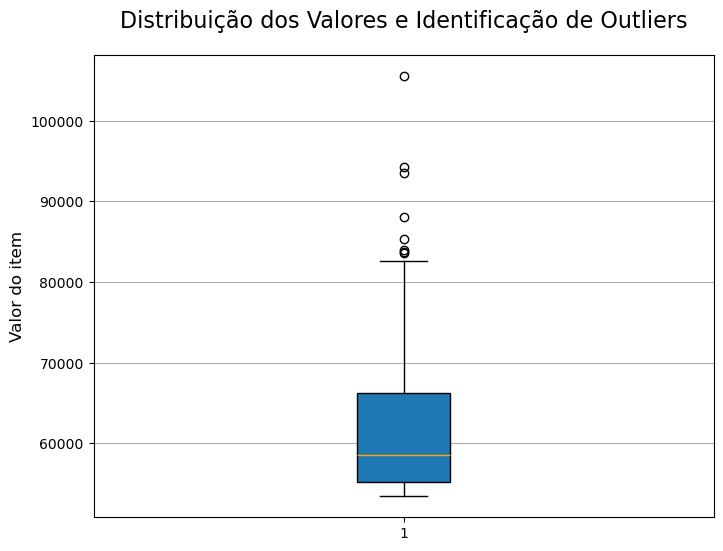

In [27]:
# Vizualizando:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.figure(figsize=(8,6))
plt.boxplot(Invoicing_total_sales, patch_artist=True, medianprops={'color': 'orange'})
plt.title('Distribuição dos Valores e Identificação de Outliers', fontsize=16, pad=20)
plt.ylabel('Valor do item',fontsize=12)
plt.grid(axis='y', linestyle='-')
#plt.text(1.1,Median_Invoicing_total_sales,'Aproximadamente 25% dos seus itens têm um valor igual ou inferior a este ponto (parece estar em torno de 58.000 - 59.000)')
#plt.text(1.2,Q2,'A linha laranja dentro da caixa representa a Mediana (Q2). Este é o valor do meio da amostra de 150 itens, o que significa que 50% dos itens têm um valor igual ou inferior a este ponto (parece estar em torno de 59.000 - 60.000)')
#plt.text(1.3,Q3,'A linha superior da caixa representa o Terceiro Quartil (Q3). Aproximadamente 75% dos seus itens têm um valor igual ou inferior a este ponto (parece estar em torno de 66.000 - 67.000).')
#plt.text(1.4,Z_score,'Todos na parte superior da distribuição, começando em torno de 80.000 e indo até mais de 100.000. Isso significa que alguns itens têm valores significativamente mais altos do que a grande maioria dos outros itens na amostra de 150.')
plt.show()



# Análise de Pareto , é uma metodologia muito utilizada na gestão de estoque e vendas para categorizar itens com base na sua importância relativa, geralmente medida pelo volume de vendas, faturamento ou consumo. A ideia central é que uma pequena porcentagem de itens (Classe A) é responsável pela maior parte do valor (ou quantidade) total.

In [28]:
# Criando uma curva de classificação dos itens: Analise de pareto dos itens;

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
# Utilizaremos os df Data_set['Value_Total_sales_Data_set']  e Invoicing_total_sales, como base na analise;

# Criando o df para manipulção e criação da curva de classificação:

# --- 1. Preparar os dados para a Análise ABC ---

# 1.1 : Total do Faturamento por itens:
Data_set['Faturamento por itens'] = Data_set['quantidade vendida'] * Data_set['valor unitario']

# 1.2: Total de faturamento :
Ord_Total_Invoicing_total = Data_set.groupby(['ID_produto','descricao'])['Faturamento por itens'].sum().sort_values(ascending=False)

# 1.3: Percentual por produto: criando dataframes para os percentuais por itens e acumulados;
df_ABC = Ord_Total_Invoicing_total.reset_index() # fizemos o reset do dataframe Ord_total_invoicing_total, para poder intervir nas colunas
df_ABC = df_ABC.rename(columns={'Faturamento por itens':'Faturamento total'}) # Renomeamos as colunas para conseguir interar nos conteudos, assim tranformamos em series o df_ABC;
# sintaxe para reset de data fame: novo_dataframe = dataframe_dads15 e_origem.resent_index()
# sintaxe para renomear as colunas no novo df: novo_dataframe.rename(columns={nome das colunas})

Total_sales_produt = df_ABC['Faturamento total'].sum()
df_ABC['Percentual individual'] = (df_ABC['Faturamento total']/Total_sales_produt)*100 # Vendas percentuais

# 1.4: Percentual acumulado por produto

df_ABC['Percentual acumulado'] = (df_ABC['Percentual individual'].cumsum())*100

# Analise custo do estoque; 
# Aqui iremos criar insights para estudar o estoque, saber se a circulação de peça atende as vendas.


    

In [29]:
# Criando uma curva de classificação dos itens: Analise de pareto dos itens; prst 2

# Bibliotecas:

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint

# Criando o limite para a curva ABC:
try:
    Limite_A = 80 # Itens que fazem parte de 80% do faturamento
    Limite_B = 95 # Itens que fazem parte de 15% do faturamento
    
    def atribuindo_class(Porcentagem_acumulada):
        if Porcentagem_acumulada <= Limite_A:
            return 'A'
        elif Porcentagem_acumulada <= Limite_B:
            return 'B'
        else: return 'C'

    df_ABC['Classe ABC'] = df_ABC['Percentual acumulado'].apply(atribuindo_class)
except KeyError as e:
    print('Erro identificado!')

# Renomeando:
Nome_arquivo = "Analise_da_curva_ABC.xlsx"
df_ABC.to_excel(Nome_arquivo, index=False)



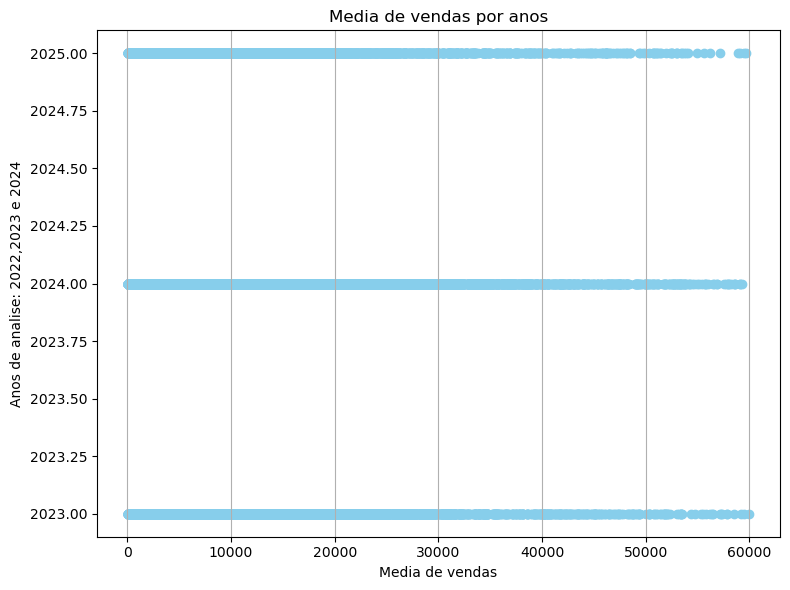

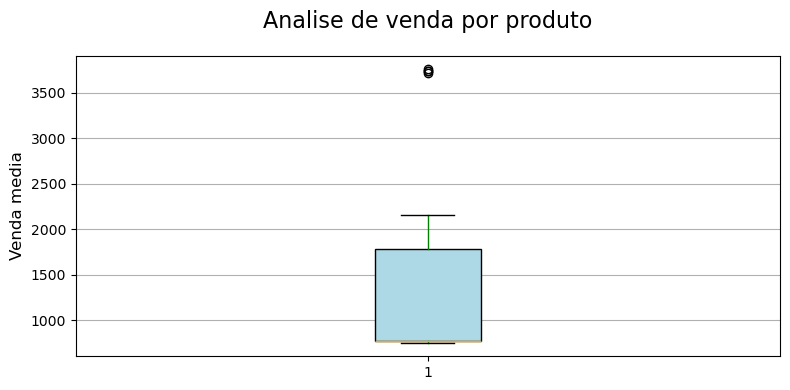

In [37]:
# Vizualizando informações:

try:
    # Analise de venda durante os anos: 2022,2023 e 2024
    
    Data_set['Valor_total_vendas'] = Data_set['quantidade vendida'] * Data_set['valor unitario']
    Data_Anos = Data_set['Anos vendas']
    
    plt.figure(figsize=(8,6))
    plt.scatter(Valor_total_vendas,Data_Anos,color='skyblue',label='Vendas por anos')
    plt.xlabel('Media de vendas')
    plt.ylabel('Anos de analise: 2022,2023 e 2024')
    plt.title('Media de vendas por anos')
    plt.tight_layout()
    plt.grid(axis='x',linestyle='-')
    plt.show()

    # Analise de venda por produto;
    
    Vendas_Produtos = [Data_set.groupby(['descricao'])['valor unitario'].mean()]
    
    plt.figure(figsize=(8,4))
    plt.boxplot(Vendas_Produtos,patch_artist=True, medianprops={'color': 'orange'},
                boxprops={'facecolor':'lightblue'},
               whiskerprops={'color':'green'},
               flierprops={'marker':'o'})
    plt.title('Analise de venda por produto', fontsize=16, pad=20)
    plt.ylabel('Venda media',fontsize=12)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='-')

    
except ValueError as e:
    print(e)
except NameError as e:
    print(e)
except KeyError as e:
    print(e)
except AttributeError as e:
    print(e)
except TypeError as e:
    print(e)
